# Imports

In [16]:
from matplotlib.colors import to_rgba
lst = [
    '#65318e',
    '#bd986d',
    '#8401ff'
]
for s in lst:
    print(str([round(v , 4) for v in to_rgba(s)]) + ',')

[0.3961, 0.1922, 0.5569, 1.0],
[0.7412, 0.5961, 0.4275, 1.0],
[0.5176, 0.0039, 1.0, 1.0],


In [1]:
import os
from PIL import Image
from typing import List

from osgeo import gdal
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba
import numpy as np
import scipy.ndimage
gdal.UseExceptions()

from apps.colors import CsColorMaps, RgbColorMaps, VintageColorMaps, Coloring
from apps.parts import process
from apps.mapper import (
    SlopeOptions, TriOptions, TpiOptions, HillshadeOptions,
    composite_images, save_image_rgba
)
from apps.kernels import Kernels

cs_cmaps = CsColorMaps()
vintage_cmaps = VintageColorMaps()
rgb_maps = RgbColorMaps()
coloring = Coloring()

In [2]:
cmap = RgbColorMaps()

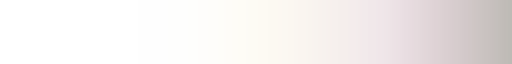

In [3]:
cmap.slope().cmap

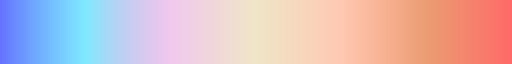

In [4]:
cmap.tpi().cmap

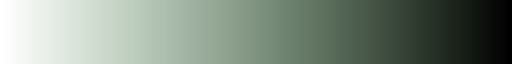

In [5]:
cmap.tri().cmap

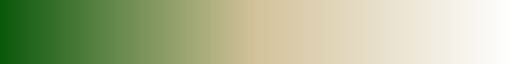

In [6]:
cmap.hillshade().cmap

In [7]:
dirname = r'D:\Repositories\ProcessingRaster\datasets\OUTPUT'
INPUT_FILE = os.path.join(dirname, 'DTM__R0_5.tif')

org_dst = gdal.Open(INPUT_FILE)

## Slope

In [8]:
slope_options = SlopeOptions(
    checked=False, 
    resampling=True, 
    resolution=10.0, 
    gaussian=True, 
    gaussian_sigma=1.0,
    cmap=cs_cmaps.slope().colors_255,
)

In [9]:
slope_img = slope_options.to_slope_img(org_dst)

## TPI

In [10]:
tpi_options = TpiOptions(
    checked=True, 
    kernel_size_type='カーネルサイズを距離で指定', 
    one_side_distance=15.0, 
    kernel_type='Doughnut', 
    sigma=5, 
    outlier_treatment=True, 
    threshold=1.5,
    cmap=cmap.tpi().colors_255,
)

In [11]:
tpi_img = tpi_options.to_tpi_img(org_dst)

## TRI

In [12]:
tri_options = TriOptions(
    checked=False, 
    outlier_treatment=True, 
    threshold=1.5,
    cmap=cmap.tri().colors_255,
)

tri_img = tri_options.to_tri_img(org_dst)

## Hillshade

In [13]:
hillshade_options = HillshadeOptions(
    checked=False, 
    hillshade_type='Single', 
    azimuth=315, 
    altitude=90, 
    z_factor=2.5, 
    combined=True,
    cmap=cmap.hillshade().colors_255,
)

hillshade_img = hillshade_options.to_hillshade_img(org_dst)

## Composite

In [16]:
composited_img = composite_images(slope_img, tpi_img, tri_img, hillshade_img)

In [17]:
# composited_img = Image.alpha_composite(hillshade_img, tri_img)
# composited_img = Image.alpha_composite(composited_img, tpi_img)
composited_img.show()

In [18]:
result = np.array(composited_img)
ary2d_lst = []
for i in range(result.shape[2]):
    ary2d_lst.append(result[:, :, i])


OUTPUT_FILE = os.path.join(dirname, 'CS-Map__R0_5.tif')
driver = gdal.GetDriverByName('GTiff')
driver.Register()
new_dst = driver.Create(
    OUTPUT_FILE,
    xsize=org_dst.RasterXSize, 
    ysize=org_dst.RasterYSize, 
    bands=4, 
    eType=gdal.GDT_Byte
)

new_dst.SetGeoTransform(org_dst.GetGeoTransform())
new_dst.SetProjection(org_dst.GetProjection())
set_colors = [
    gdal.GCI_RedBand,
    gdal.GCI_GreenBand,
    gdal.GCI_BlueBand,
    gdal.GCI_AlphaBand
]
for i, (write_img, set_color) in enumerate(zip(ary2d_lst, set_colors), start=1):
    band = new_dst.GetRasterBand(i)
    band.WriteArray(write_img)
    band.SetColorInterpretation(set_color)

new_dst.FlushCache()
new_dst = None

# Show result image.

In [19]:
img_dst = gdal.Open(OUTPUT_FILE)
img = img_dst.ReadAsArray()

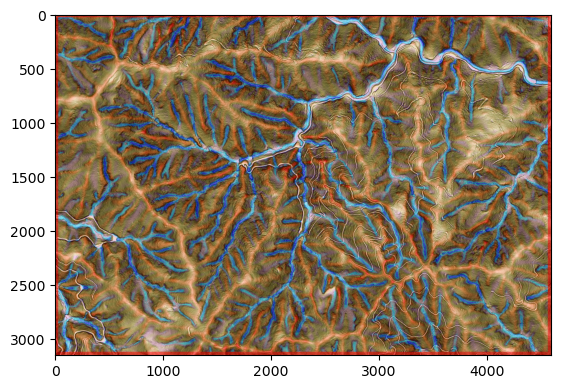

In [20]:
plt.imshow(np.dstack(img))
plt.show()

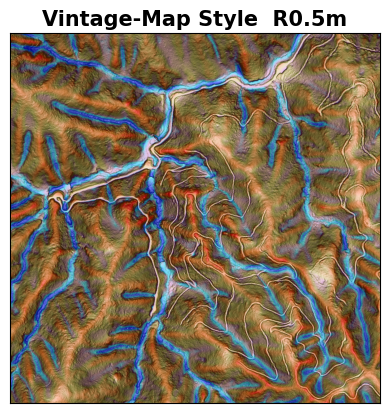

In [21]:
show_img = np.dstack(img[:3, 500: 2500, 1500: 3500])
plt.title('Vintage-Map Style  R0.5m', fontsize=15, fontweight='bold')
plt.imshow(show_img)
plt.yticks([])
plt.xticks([])
plt.show()

In [22]:
Image.fromarray(show_img).save(os.path.join(dirname, 'RGB-Map__Img.jpg'), 'JPEG', quality=95)

In [23]:
img_dst = None

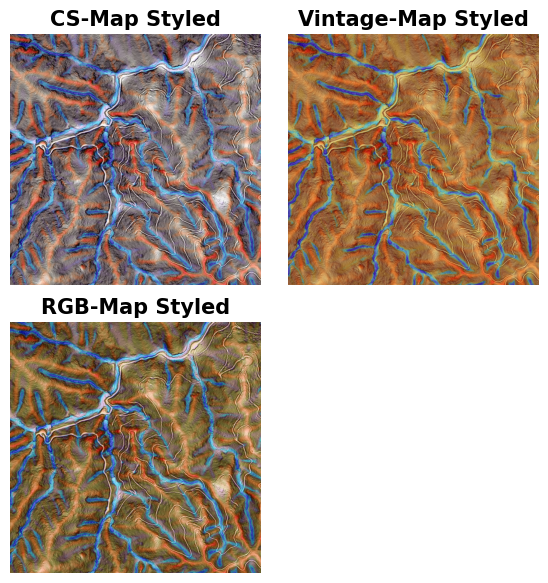

In [32]:
from matplotlib import pyplot as plt
imgs = [
    plt.imread(r'./views/CS-Map__Img.jpg'),
    plt.imread(r'./views/Vintage-Map__Img.jpg'),
    plt.imread(r'./views/RGB-Map__Img.jpg'),
]
titles = ['CS-Map Styled', 'Vintage-Map Styled', 'RGB-Map Styled']

fig = plt.figure(figsize=(7, 7))
_ax = None
for i, (img, title) in enumerate(zip(imgs, titles), start=1):
    ax = fig.add_subplot(2, 2, i, sharex=_ax, sharey=_ax)
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.imshow(img)
    ax.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.show()

In [ ]:
2000: 5000, 4000: 7500

In [17]:
import shapely
import rasterio
import rasterio.warp
import rasterio.plot

dst = gdal.Open(r"D:\Repositories\ProcessingRaster\datasets\DTM_Kouchi__R0_5M.tif")
transform = dst.GetGeoTransform()
transform

(-59000.0, 0.5, 0.0, 22000.0, 0.0, -0.5)